In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Set the base path
weights_path = 'results/kdv/weights_u'
data_path = 'results/kdv/data_u'

In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import time

In [6]:
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff

In [7]:
from koopmanlib.kdv_functions import *
from koopmanlib.functions import *

In [8]:
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)

# Set the initial conditions.
y0 = kdv_exact(x, seed=123) 

# inner loop
# # Set the time sample grid.
# dt = 0.4 / (Nx**2)
T = 0.01
# Nt = int(T / dt)
# dt = T / Nt
# t = np.linspace(0, T, Nt)

In [9]:
def v_func(x, c):
    return np.exp(-25 * (x - c)**2)

c1, c2, c3 = -np.pi/2, 0, np.pi/2
v1 = v_func(x, c1).reshape(1,-1)
v2 = v_func(x, c2).reshape(1,-1)
v3 = v_func(x, c3).reshape(1,-1)

v_list = np.concatenate([v1,v2,v3], axis=0)

In [10]:
umax = 1
umin = -umax

# Generate data

In [11]:
target_dim = Nx
param_dim = 3
# n_init = 1000
# traj_len = 200

In [12]:
# traj_len = 500

# n_init = 100

# seed_IC = np.random.randint(0,100,size=(n_init,))
# seed_IC

# y0_list = []
# for seed in seed_IC:
#     y0 = kdv_exact(x, seed)
#     y0_list.append(y0)
# y0_list = np.asarray(y0_list)

# y0_list.shape

# param_list_group = np.random.uniform(low=0, high=1, size=(n_init, traj_len, param_dim)) * (umax - umin) + umin

# soln_outer_list = []
# for y0, param_list in zip(y0_list, param_list_group):
#     # Calculate inner solution for each y0 and param_list (for one trajectory)
#     soln_inner_list = [y0]
#     for param in param_list:
#         # Solve the equation using the scipy integrator
#         soln = kdv_solution(y0, t, L, param, v_list)
#         y0 = soln[-1]
#         soln_inner_list.append(y0)

#     soln_inner_list = np.asarray(soln_inner_list)
    
#     soln_outer_list.append(soln_inner_list)
    
# soln_outer_list = np.asarray(soln_outer_list)

# soln_outer_list.shape

# param_list_group.shape

# data_x = soln_outer_list[:,:-1,:].reshape(-1, target_dim)
# data_y = soln_outer_list[:,1:,:].reshape(-1, target_dim)
# data_u = param_list_group.reshape(-1,param_dim)

In [13]:
# # Save the array to a CSV file
# np.savetxt('results/kdv/data/kdv_data_x.csv', data_x, delimiter=',')
# np.savetxt('results/kdv/data/kdv_data_y.csv', data_y, delimiter=',')
# np.savetxt('results/kdv/data/kdv_data_u.csv', data_u, delimiter=',')

In [14]:
# # Load the CSV file
# data_x = np.loadtxt('results/kdv/data/kdv_data_x_500.csv', delimiter=',')
# data_y = np.loadtxt('results/kdv/data/kdv_data_y_500.csv', delimiter=',')
# data_u = np.loadtxt('results/kdv/data/kdv_data_u_500.csv', delimiter=',')

In [15]:
print('load data')
X = pd.read_csv(os.path.join(data_path,'kdv_X.csv'), header=None)
Y = pd.read_csv(os.path.join(data_path,'kdv_Y.csv'), header=None)
U = pd.read_csv(os.path.join(data_path,'kdv_U.csv'), header=None)

data_x = X.values.T
data_y = Y.values.T
data_u = U.values.T

load data


# Build model

In [16]:
from koopmanlib.dictionary import PsiNN, PsiNN_obs
from koopmanlib.param_solver import KoopmanParametricDLSolver

In [17]:
from koopmanlib.param_solver import KoopmanBilinearDLSolver

In [18]:
from tensorflow.keras.optimizers import Adam

In [19]:
n_psi_train = 3
n_psi = 1 + 1 +1 + n_psi_train # constant + momentum + mean + NN

In [20]:
dic_bilinear = PsiNN_obs(layer_sizes=[16,16], n_psi_train=n_psi_train, dx=dx)

In [21]:
solver_bilinear = KoopmanBilinearDLSolver(dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)

In [22]:
model_bilinear = solver_bilinear.build_model()

2023-09-19 13:31:48.947098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
zeros_data_y_train = tf.zeros_like(dic_bilinear(data_y))

In [24]:
# solver_bilinear.build(model_bilinear,
#                     data_x,
#                     data_u, 
#                     data_y, 
#                     zeros_data_y_train,
#                     epochs=20,
#                     batch_size=200,
#                     lr=1e-4,
#                     log_interval=20,
#                     lr_decay_factor=0.8)

In [25]:
# solver_bilinear.model.save_weights(os.path.join(weights_path, 'bilinear_kdv_mass_momentum_weights_psi3.h5'))

In [26]:
solver_bilinear.model.load_weights(os.path.join(weights_path, 'bilinear_kdv_mass_momentum_weights_psi3.h5'))

In [27]:
# solver_bilinear.model.summary()

# Prediction

In [28]:
def compute_bilinear_obs(y0, param_list, B_obs):
    param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1,-1)
    psi_y = solver_bilinear.dic.call(y0)
    obs_list = [psi_y@B_obs]
    
    for param in param_list:
        u_psiy = tf.einsum('ij,ik->kij', psi_y, param)
        u_psiy_list = []
        for curr in u_psiy:
            u_psiy_list.append(curr)
        u_psiy_list = tf.concat(u_psiy_list, axis=-1)
        
        psi_y = solver_bilinear.model.get_layer('Layer_A')(psi_y) + solver_bilinear.model.get_layer('Layer_B')(u_psiy_list)
        obs_next = psi_y@B_obs
        obs_list.append(obs_next)
        
    return np.squeeze(np.asarray(obs_list))

In [29]:
def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv_solution(y0_loop, T, L, param, v_list, x)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list

In [30]:
# # # Forward prediction problem setting
# # y0_pred = kdv_exact(x, seed=11) 
# # Tsim_pred = 0.1

# # traj_len_pred = int(Tsim_pred / T)

# # # Set the seed of param_list
# # np.random.seed(123)

# # param_list_pred = np.random.uniform(low=0, high=1, size=(traj_len_pred,param_dim)) * (umax - umin) + umin

# # # kdv_soln_pred = np.loadtxt(os.path.join(data_path,'kdv_soln_pred.csv'), delimiter=',')
# # # bilinear_kdv_mass_pred = np.loadtxt(os.path.join(data_path,'bilinear_kdv_mass_pred.csv'), delimiter=',')

# # # Compute exact solution
# # kdv_soln_pred = compute_kdv_soln(y0_pred, param_list=param_list_pred)
# # kdv_soln_pred = np.asarray(kdv_soln_pred)

# # kdv_mass_pred = tf.reshape(tf.math.reduce_sum(kdv_soln_pred, axis=-1), shape=(-1,1))

# # # Compute bilinear results
# # B_mass = dic_bilinear.generate_B_mass(kdv_mass_pred)
# # # B_momentum = dic_bilinear.generate_B_momentum(kdv_momentum_pred)

# # bilinear_kdv_mass_pred = compute_bilinear_obs(y0_pred, param_list_pred, B_mass)
# # # bilinear_kdv_momentum_pred = compute_bilinear_obs(y0_pred, param_list_pred, B_momentum)

# # # Comparison
# # plt.plot(kdv_mass_pred, label='kdv eq')
# # plt.plot(bilinear_kdv_mass_pred, label='bilinear')
# # plt.legend()

# # np.savetxt('results/kdv/data_nonlinear/bilinear_kdv_mass_pred.csv', bilinear_kdv_mass_pred , delimiter=',')
# # np.savetxt('results/kdv/data_nonlinear/bilinear_kdv_momentum_pred.csv', bilinear_kdv_momentum_pred, delimiter=',')

# bilinear_kdv_mass_pred = bilinear_kdv_mass_pred.reshape((-1,1))

# error = compute_diff_ratio_one_traj(kdv_mass_pred, bilinear_kdv_mass_pred)

# plt.plot(error)

In [31]:
pred_traj_number = 5
np.random.seed(12)
seed_list = np.random.randint(low=1, high=200, size=(pred_traj_number,2))

y0_pred_list=[]
param_pred_list = []

Tsim_pred = 0.1
traj_len_pred = int(Tsim_pred / T)

for seed_x, seed_u in seed_list:
    # Forward prediction problem setting
    y0_pred = kdv_exact(x, seed=seed_x) 
    

    # Set the seed of param_list
    np.random.seed(seed_u)

    param_pred = np.random.uniform(low=0, high=1, size=(traj_len_pred, param_dim)) * (umax - umin) + umin
    
    y0_pred_list.append(y0_pred)
    param_pred_list.append(param_pred)


In [181]:
error_mass_list_bilinear, error_momentum_list_bilinear = compute_obs_error(dic=dic_bilinear,
                                                                       compute_kdv_soln_func=compute_kdv_soln,
                                                                       compute_obs_func_model=compute_bilinear_obs,
                                                                       error_func=compute_diff_ratio_one_traj,
                                                                       y0_pred_list=y0_pred_list,
                                                                       param_pred_list=param_pred_list,
                                                                       dx=dx)

In [182]:
mass_mean_bilinear, mass_std_bilinear, mass_mean_plus_bilinear, mass_mean_minus_bilinear = compute_stat_info(error_mass_list_bilinear)
momentum_mean_bilinear, momentum_std_bilinear, momentum_mean_plus_bilinear, momentum_mean_minus_bilinear = compute_stat_info(error_momentum_list_bilinear)

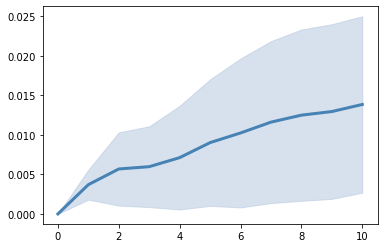

In [183]:
t_axis = np.arange(0, traj_len_pred+1, 1)

plt.plot(mass_mean_bilinear, label='P-Koopman', color='steelblue', linewidth=3)
plt.fill_between(t_axis, np.maximum(mass_mean_minus_bilinear,0), mass_mean_plus_bilinear, color='lightsteelblue', alpha=0.5)

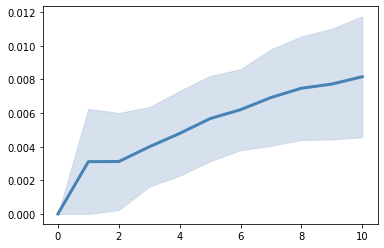

In [184]:
t_axis = np.arange(0, traj_len_pred+1, 1)

plt.plot(momentum_mean_bilinear, label='P-Koopman', color='steelblue', linewidth=3)
plt.fill_between(t_axis, np.maximum(momentum_mean_minus_bilinear,0), momentum_mean_plus_bilinear, color='lightsteelblue', alpha=0.5)

In [58]:
# dict_error_bilinear = {'mean': mean_bilinear,
#              'std': std_bilinear,
#              'mean_plus':mean_plus_bilinear,
#              'mean_minus':mean_minus_bilinear}
# np.save(os.path.join(data_path,'error_bilinear.npy'), dict_error_bilinear)

# Tracking Problem

In [28]:
def compute_stat_info(data):
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    mean_plus_std = data_mean + data_std
    mean_minus_std = data_mean - data_std
    return data_mean, data_std, mean_plus_std, mean_minus_std

In [29]:
from scipy.optimize import minimize

In [30]:
# Testing reference
y0_track = np.zeros(shape=(Nx, )) + 0.2

In [31]:
# y0_track = kdv_exact(x, seed=10)

In [32]:

Tsim_track = 10

traj_len_track = int(Tsim_track / T)



### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim))+0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5

In [33]:
tau = 10

In [34]:
# soln_ref = np.loadtxt(os.path.join(data_path,'track_soln_ref'), delimiter=',')

In [35]:
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1,1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1,1))

In [36]:
def mpc_loss_bilinear(param, tau, ref_list, y0, B):
    param = tf.reshape(param, shape=(int(param.shape[0]/param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1,-1)
    psi_y = solver_bilinear.dic.call(y0)
    
    for i in range(tau):
        
        u_psiy = tf.einsum('ij,ik->kij', psi_y, param[i])
        u_psiy_list = []
        for curr in u_psiy:
            u_psiy_list.append(curr)
        u_psiy_list = tf.concat(u_psiy_list, axis=-1)
        
        psi_y = solver_bilinear.model.get_layer('Layer_A')(psi_y) + solver_bilinear.model.get_layer('Layer_B')(u_psiy_list)
        obs = psi_y@B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs))
        loss_list.append(loss_curr)
    
    ref_loss= tf.reduce_sum(loss_list)
    param_loss = 0.005 * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))
    
    loss = ref_loss + param_loss
    
#     loss = ref_loss
    return loss   

In [37]:
def KoopmanMPC(y0, tau, traj_len, soln_ref, kdv_solver, B, loss):
    
    bounds= []
    for i in range(tau*param_dim):
        bounds.append((-1,1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []
    for current_time in range(traj_len-tau-1):
        print('current time step: ', current_time)
        start_time = time.time()
        # This needs param_init is a scalor

        param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim, )) * (umax - umin) + umin

        results = minimize(loss, 
                       x0=param_init,
                       args = (tau, soln_ref[current_time+1:current_time+1+tau,:], y0_mpc_loop_list[-1], B),
                       bounds=bounds)

        param = results.x.reshape(tau, param_dim)[0]
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, L, param, v_list, x)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)
        end_time = time.time()

        print('loss: ', results.fun)
#         print('time: ', end_time-start_time)
        
    current_time = current_time + 1
        
    print('current time step: ', current_time)
    start_time = time.time()
    # This needs param_init is a scalor

    param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim, )) * (umax - umin) + umin

    results = minimize(loss, 
                   x0=param_init,
                   args = (tau, soln_ref[current_time+1:current_time+1+tau,:], y0_mpc_loop_list[-1], B),
                   bounds=bounds)

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, L, param_curr, v_list, x)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)
        end_time = time.time()

    print('loss: ', results.fun)
        
    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)
    
    return opt_control_list, y0_mpc_loop_list

In [38]:
B_mass = dic_bilinear.generate_B_mass(mass_ref)
B_momentum = dic_bilinear.generate_B_momentum(momentum_ref)

## Track mass

In [39]:
bilinear_opt_control_mass, bilinear_kdv_opt_mass_soln = KoopmanMPC(y0=y0_track,
                                                                   tau=tau,
                                                traj_len=traj_len_track,
                                                soln_ref=mass_ref, 
                                                kdv_solver=kdv_solution,
                                                B=B_mass,
                                                loss=mpc_loss_bilinear)

current time step:  0
loss:  3.4556674231791993
current time step:  1
loss:  3.33430749702124
current time step:  2
loss:  3.215201112504207
current time step:  3
loss:  3.0983482940086917
current time step:  4
loss:  2.9837490538665943
current time step:  5
loss:  2.871403396793485
current time step:  6
loss:  2.761311308300248
current time step:  7
loss:  2.653472545717157
current time step:  8
loss:  2.5478776057268417
current time step:  9
loss:  2.4445215554109976
current time step:  10
loss:  2.3434044026297474
current time step:  11
loss:  2.2445261535219467
current time step:  12
loss:  2.1478868071526582
current time step:  13
loss:  2.053486358405075
current time step:  14
loss:  1.9613248009415043
current time step:  15
loss:  1.8714021314779623
current time step:  16
loss:  1.783718351783364
current time step:  17
loss:  1.6982734689146834
current time step:  18
loss:  1.6150674830768816
current time step:  19
loss:  1.5340978339498945
current time step:  20
loss:  1.455345

loss:  1.6570852893654977e-07
current time step:  161
loss:  1.4651323588697906e-07
current time step:  162
loss:  1.2968746991005534e-07
current time step:  163
loss:  1.3545996120650418e-07
current time step:  164
loss:  1.5212979854576732e-07
current time step:  165
loss:  8.61284475149358e-08
current time step:  166
loss:  7.62809706073747e-08
current time step:  167
loss:  6.754221740428053e-08
current time step:  168
loss:  5.982380379534408e-08
current time step:  169
loss:  5.303782206242211e-08
current time step:  170
loss:  4.7155608387882595e-08
current time step:  171
loss:  4.178881520825853e-08
current time step:  172
loss:  3.70859239151191e-08
current time step:  173
loss:  3.282231352539341e-08
current time step:  174
loss:  2.912913140248652e-08
current time step:  175
loss:  2.581568261725207e-08
current time step:  176
loss:  2.2846643560783872e-08
current time step:  177
loss:  2.0284080984479727e-08
current time step:  178
loss:  5.4052520793907584e-08
current tim

loss:  3.2074817223962745e-11
current time step:  315
loss:  2.937725680422444e-11
current time step:  316
loss:  2.6435829325237966e-11
current time step:  317
loss:  1.2054639356603622e-08
current time step:  318
loss:  3.488989115391992e-11
current time step:  319
loss:  3.5813022761368944e-11
current time step:  320
loss:  2.81886821993599e-11
current time step:  321
loss:  3.246452845476112e-11
current time step:  322
loss:  1.7360147856184783e-08
current time step:  323
loss:  7.293138099340443e-11
current time step:  324
loss:  6.437516271524356e-11
current time step:  325
loss:  5.7704887115746526e-11
current time step:  326
loss:  5.293089677718471e-11
current time step:  327
loss:  4.3774947385436194e-11
current time step:  328
loss:  4.9258425891822304e-11
current time step:  329
loss:  3.3060906160814186e-11
current time step:  330
loss:  3.009633523739723e-11
current time step:  331
loss:  2.892134749482895e-11
current time step:  332
loss:  2.1463569595029157e-11
current 

loss:  5.377507531452763e-08
current time step:  469
loss:  1.2499030836088282e-09
current time step:  470
loss:  1.1079479636340074e-09
current time step:  471
loss:  9.781536262881786e-10
current time step:  472
loss:  1.269412389568952e-08
current time step:  473
loss:  3.3153343552000615e-10
current time step:  474
loss:  2.9603765117748955e-10
current time step:  475
loss:  2.525501648759635e-10
current time step:  476
loss:  2.253442673127362e-10
current time step:  477
loss:  1.9561033103502135e-10
current time step:  478
loss:  1.7300875066087907e-10
current time step:  479
loss:  1.5018811759399756e-10
current time step:  480
loss:  1.322541815241884e-10
current time step:  481
loss:  2.8568005876239563e-08
current time step:  482
loss:  2.978168164455629e-11
current time step:  483
loss:  3.2220092545323805e-08
current time step:  484
loss:  4.4375145804454713e-10
current time step:  485
loss:  3.9081584510683296e-10
current time step:  486
loss:  3.4939298632640084e-10
curre

loss:  0.002663872953201912
current time step:  632
loss:  0.002358813634731413
current time step:  633
loss:  0.00208868572486483
current time step:  634
loss:  0.0018494828543962794
current time step:  635
loss:  0.0016376643955246472
current time step:  636
loss:  0.0014501263241537385
current time step:  637
loss:  0.0012840775079599773
current time step:  638
loss:  0.0011370047742525328
current time step:  639
loss:  0.0010067827284788002
current time step:  640
loss:  0.000891509058413658
current time step:  641
loss:  0.0007893995370713242
current time step:  642
loss:  0.0006989899472285385
current time step:  643
loss:  0.0006189481166958451
current time step:  644
loss:  0.0005480475936232284
current time step:  645
loss:  0.0004852830931940047
current time step:  646
loss:  0.00042971829562940187
current time step:  647
loss:  0.0003805182766729494
current time step:  648
loss:  0.00033694718546283117
current time step:  649
loss:  0.0002983669813095802
current time step:  

loss:  1.3211389780224312e-10
current time step:  786
loss:  3.637870731239832e-08
current time step:  787
loss:  8.208991378262413e-10
current time step:  788
loss:  7.233347176125177e-10
current time step:  789
loss:  6.413290931920057e-10
current time step:  790
loss:  5.623125659965308e-10
current time step:  791
loss:  4.900756969994497e-10
current time step:  792
loss:  4.2480958403695173e-10
current time step:  793
loss:  3.695047942519272e-10
current time step:  794
loss:  3.491807495600793e-10
current time step:  795
loss:  2.9199880074941675e-10
current time step:  796
loss:  2.6046199671979813e-10
current time step:  797
loss:  2.345461694259846e-10
current time step:  798
loss:  2.689594314185641e-10
current time step:  799
loss:  1.6270309061179742e-10
current time step:  800
loss:  1.5251406554434366e-10
current time step:  801
loss:  1.241006542267176e-10
current time step:  802
loss:  1.1432298602339285e-10
current time step:  803
loss:  1.0537613575537639e-10
current t

loss:  6.1498197239229426e-12
current time step:  940
loss:  7.247754409482723e-12
current time step:  941
loss:  3.81709769710385e-11
current time step:  942
loss:  2.240411935478851e-12
current time step:  943
loss:  3.9795214083136575e-12
current time step:  944
loss:  1.75522924553057e-09
current time step:  945
loss:  2.2121037584601042e-11
current time step:  946
loss:  1.5945493171138767e-11
current time step:  947
loss:  2.2542802893685616e-11
current time step:  948
loss:  4.828848508863476e-08
current time step:  949
loss:  5.424705697547205e-10
current time step:  950
loss:  4.839872495772865e-10
current time step:  951
loss:  4.2704289705684035e-10
current time step:  952
loss:  3.8188068752102304e-10
current time step:  953
loss:  3.4332136676774436e-10
current time step:  954
loss:  2.9391302632752423e-10
current time step:  955
loss:  2.7203427085662125e-08
current time step:  956
loss:  5.841374818200096e-11
current time step:  957
loss:  4.9136772928917775e-11
current 

In [40]:
np.savetxt(os.path.join(data_path,'mpc/0.005_penalty_bilinear_mass_kdv_opt_control.csv'), bilinear_opt_control_mass, delimiter=',')
np.savetxt(os.path.join(data_path,'mpc/0.005_penalty_bilinear_mass_kdv_opt_soln.csv'), bilinear_kdv_opt_mass_soln, delimiter=',')

In [41]:
# bilinear_opt_control_mass = np.loadtxt(os.path.join(data_path,'bilinear_mass_kdv_opt_control_20s_greedy.csv'), delimiter=',')
# bilinear_kdv_opt_mass_soln = np.loadtxt(os.path.join(data_path,'bilinear_mass_kdv_opt_soln_20s_greedy.csv'), delimiter=',')

In [42]:
bilinear_kdv_opt_mass = dx * tf.reduce_sum(bilinear_kdv_opt_mass_soln, axis=-1)

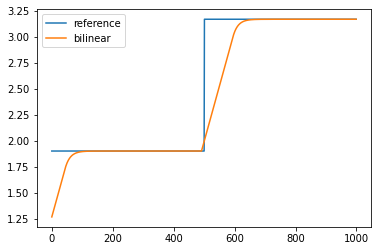

In [43]:
plt.plot(mass_ref, label='reference')
plt.plot(bilinear_kdv_opt_mass, label='bilinear')
plt.legend()

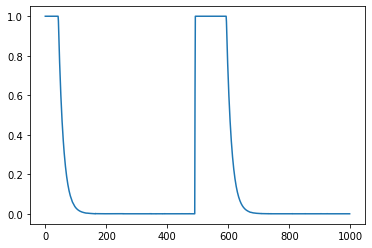

In [44]:
plt.plot(bilinear_opt_control_mass[:,2])

## Track momentum

In [45]:
bilinear_opt_control_momentum, bilinear_kdv_opt_momentum_soln = KoopmanMPC(y0=y0_track,
                                                                           tau=tau,
                                                traj_len=traj_len_track,
                                                soln_ref=momentum_ref, 
                                                kdv_solver=kdv_solution,
                                                B=B_momentum,
                                                loss=mpc_loss_bilinear)

current time step:  0
loss:  0.9553810280097281
current time step:  1
loss:  0.9312629632295762
current time step:  2
loss:  0.9063824718699399
current time step:  3
loss:  0.8826296111605408
current time step:  4
loss:  0.8599643019056009
current time step:  5
loss:  0.8376280989508115
current time step:  6
loss:  0.8150013228976776
current time step:  7
loss:  0.7919676737961133
current time step:  8
loss:  0.7689586309605118
current time step:  9
loss:  0.7466952122967299
current time step:  10
loss:  0.7253073984993705
current time step:  11
loss:  0.7044181281585218
current time step:  12
loss:  0.6835734789634086
current time step:  13
loss:  0.6625353977109278
current time step:  14
loss:  0.64137589550408
current time step:  15
loss:  0.6204333344683063
current time step:  16
loss:  0.6002351768652038
current time step:  17
loss:  0.5811593419946215
current time step:  18
loss:  0.5629593577113035
current time step:  19
loss:  0.5451461542819483
current time step:  20
loss:  0.


KeyboardInterrupt



In [ ]:
bilinear_kdv_opt_momentum = dx * tf.reshape(tf.math.reduce_sum(tf.square(bilinear_kdv_opt_momentum_soln), axis=-1), shape=(-1,1))

In [ ]:
plt.plot(momentum_ref, label='reference')
plt.plot(bilinear_kdv_opt_momentum, label='bilinear')
plt.legend()

In [ ]:
np.savetxt(os.path.join(data_path,'mpc/0.005_penalty_bilinear_momentum_kdv_opt_control.csv'), bilinear_opt_control_momentum, delimiter=',')
np.savetxt(os.path.join(data_path,'mpc/0.005_penalty_bilinear_momentum_kdv_opt_soln.csv'), bilinear_kdv_opt_momentum_soln, delimiter=',')

# Controllability

In [53]:
# Randomly sample control
np.random.seed(seed=111)
n_control_samples = 2000
control_samples = np.random.uniform(low=0, high=1, size=(n_control_samples, param_dim)) * (umax - umin) + umin

In [54]:
control_samples_repeat = np.repeat(control_samples[:, np.newaxis, :], n_psi, axis=1)

In [55]:
control_samples_repeat.shape

(2000, 4, 3)

In [56]:
psi_y = np.eye(n_psi)
psi_y.shape

(4, 4)

In [57]:
bilinear_K_matrix = []
for param in control_samples_repeat:
    u_psiy = tf.einsum('ij,ik->kij', psi_y, param)
    u_psiy_list = []
    for curr in u_psiy:
        u_psiy_list.append(curr)
    u_psiy_list = tf.concat(u_psiy_list, axis=-1)

    psi_y_next = solver_bilinear.model.get_layer('Layer_A')(psi_y) + solver_bilinear.model.get_layer('Layer_B')(u_psiy_list)
    bilinear_K_matrix.append(psi_y_next)

In [58]:
bilinear_K_matrix = np.asarray(bilinear_K_matrix)

In [59]:
bilinear_K_matrix.shape

(2000, 4, 4)

In [60]:
identity_matrix = np.eye(N=bilinear_K_matrix.shape[-1])

bilinear_A_matrix = (bilinear_K_matrix - identity_matrix) / T

bilinear_A_vector = tf.reshape(bilinear_A_matrix, shape=(bilinear_A_matrix.shape[0], bilinear_A_matrix.shape[-1]*bilinear_A_matrix.shape[-1]))

rank = np.linalg.matrix_rank(bilinear_A_vector)

U, S, VT = np.linalg.svd(bilinear_A_vector)

In [61]:
np.sum(S > 1e-5)

4

In [62]:
S

array([1.12498421e+03, 2.69765782e+02, 8.40963622e+01, 1.05078041e+01,
       2.82185967e-13, 2.73238965e-13, 1.60711858e-13, 1.35440437e-13,
       1.32707671e-14, 6.22200437e-15, 1.13119939e-15, 2.12596166e-17,
       1.27832280e-17, 2.35725666e-24, 4.20409899e-25, 4.57139378e-27])

In [63]:
# Check the rank of psi_y

psi_x = dic_bilinear(data_x[:2000,:])

U_x, S_x, VT_x = np.linalg.svd(psi_x.numpy())

S_x

array([9.32574671e+02, 4.37357989e+01, 4.91028004e-01, 6.43728204e-02])